## This version uses the correct matrices in the linear equation. It however seems to give nearly indentical results to my previous version.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

/Users/dreiss/lsstsw/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def gaussian(x, m=0., s=1.0):
    out = 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)**2./(2.*s**2.))
    return out / out.sum() / (x[1] - x[0])

In [53]:
x = np.arange(-15, 16, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
grid = np.dstack((y0, x0))

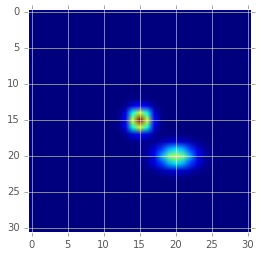

In [54]:
from scipy.stats import multivariate_normal

## see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.multivariate_normal.html

def gaussian2d(grid, m=None, s=None):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    var = scipy.stats.multivariate_normal(mean=m, cov=cov)
    return var.pdf(grid)

#x, y = np.mgrid[-15:16:1, -15:16:1]
#grid = np.dstack((x, y))
g1 = gaussian2d(grid) + gaussian2d(grid, [5,5], [3,1])
plt.imshow(g1)

## Update: it looks like the actual code uses chebyshev1 polynomials!

Note these are essentially the same but with different scale factors.

In [56]:
# This code works, but I think the next cell is faster.
from numpy.polynomial.chebyshev import chebgrid2d

h0 = chebgrid2d(x, y, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebgrid2d(x, y, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebgrid2d(x, y, c=[[0, 1, 0], [0, 0, 1]])

In [59]:
from numpy.polynomial.chebyshev import chebval2d
h0 = chebval2d(x0, y0, c=[[1, 0, 0], [1, 0, 0]])
h1 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 1, 0]])
h2 = chebval2d(x0, y0, c=[[1, 0, 0], [0, 1, 0]])
h3 = chebval2d(x0, y0, c=[[0, 1, 0], [0, 0, 1]])

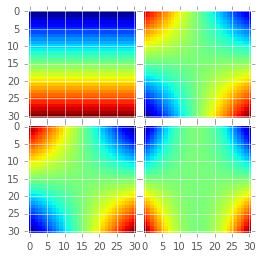

In [122]:
from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
igrid[0].imshow(h0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(h1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(h2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(h3, interpolation='none')  # The AxesGrid object work as a list of axes.

In [44]:
## The following code does exactly the same as the above:
from numpy.polynomial.chebyshev import chebval
def chebval2d_try(x, y, xord, yord):
    cx = chebval(x, xord)
    cy = chebval(y, yord)
    h0 = np.outer(cx, cy)
    return h0

if False:
    #h0 = chebval2d_try(x, y, [1, 0, 0], [0, 1, 0])
    h0 = chebval2d_try(x, y, [0, 1, 0], [0, 1, 0])
    #h0 = chebval2d_try(x, y, [0, 1, 0], [0, 0, 1])
    print h0.shape
    plt.imshow(h0)

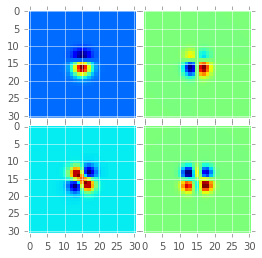

In [123]:
gh0 = gaussian2d(grid, s=[3., 3.]) * h0
gh1 = gaussian2d(grid, s=[3., 3.]) * h1
gh2 = gaussian2d(grid, s=[3., 3.]) * h2
gh3 = gaussian2d(grid, s=[3., 3.]) * h3
fig = plt.figure(1, (4., 4.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )
extent = (x0.min(), x0.max(), y0.min(), y0.max())
igrid[0].imshow(gh0, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[1].imshow(gh1, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[2].imshow(gh2, interpolation='none')  # The AxesGrid object work as a list of axes.
igrid[3].imshow(gh3, interpolation='none')  # The AxesGrid object work as a list of axes.

## Generate AL basis funcs now...

use same parameters as from the stack.

In [75]:
ord=[[0,1],[0,0,1]]
np.max([len(ord[0]), len(ord[1])])

3

In [126]:
# Parameters from stack
sigGauss = [0.75, 1.5, 3.0]
degGauss = [4, 2, 2]
betaGauss = 1   # in the Becker et al. paper sigGauss is 1 but PSF is more like 2 pixels?
# Parameters from and Becker et al. (2012)
#sigGauss = [0.75, 1.5, 3.0]
#degGauss = [6, 4, 2]

def chebGauss2d(x, y, grid, m=None, s=None, ord=[0,0], beta=1., verbose=False):
    if m is None:
        m = [0., 0.]
    if s is None:
        s = [1., 1.]
    cov = [[s[0], 0], [0, s[1]]]
    coefLen = np.max([ord[0], ord[1]])
    coef0 = np.zeros(coefLen+1)
    coef0[ord[0]] = 1
    coef1 = np.zeros(coefLen+1)
    coef1[ord[1]] = 1
    if verbose:
        print s, ord, coef0, coef1
    ga = gaussian2d(grid, m, np.array(s)/beta)
    ch = chebval2d(x, y, c=[coef0, coef1])
    return ga * ch

In [127]:
basis = [chebGauss2d(x0, y0, grid, m=[0,0], s=[sig0,sig1], ord=[deg0,deg1], beta=betaGauss, verbose=True) for i0,sig0 in enumerate(sigGauss) for deg0 in range(degGauss[i0]) for i1,sig1 in enumerate(sigGauss) for deg1 in range(degGauss[i1])]

[0.75, 0.75] [0, 0] [ 1.] [ 1.]
[0.75, 0.75] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [0, 2] [ 1.  0.  0.] [ 0.  0.  1.]
[0.75, 0.75] [0, 3] [ 1.  0.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 1.5] [0, 0] [ 1.] [ 1.]
[0.75, 1.5] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 3.0] [0, 0] [ 1.] [ 1.]
[0.75, 3.0] [0, 1] [ 1.  0.] [ 0.  1.]
[0.75, 0.75] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 0.75] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [1, 2] [ 0.  1.  0.] [ 0.  0.  1.]
[0.75, 0.75] [1, 3] [ 0.  1.  0.  0.] [ 0.  0.  0.  1.]
[0.75, 1.5] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 1.5] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 3.0] [1, 0] [ 0.  1.] [ 1.  0.]
[0.75, 3.0] [1, 1] [ 0.  1.] [ 0.  1.]
[0.75, 0.75] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 0.75] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 0.75] [2, 2] [ 0.  0.  1.] [ 0.  0.  1.]
[0.75, 0.75] [2, 3] [ 0.  0.  1.  0.] [ 0.  0.  0.  1.]
[0.75, 1.5] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.75, 1.5] [2, 1] [ 0.  0.  1.] [ 0.  1.  0.]
[0.75, 3.0] [2, 0] [ 0.  0.  1.] [ 1.  0.  0.]
[0.

(31, 31) (31, 31) (31, 31, 2) (31, 31)


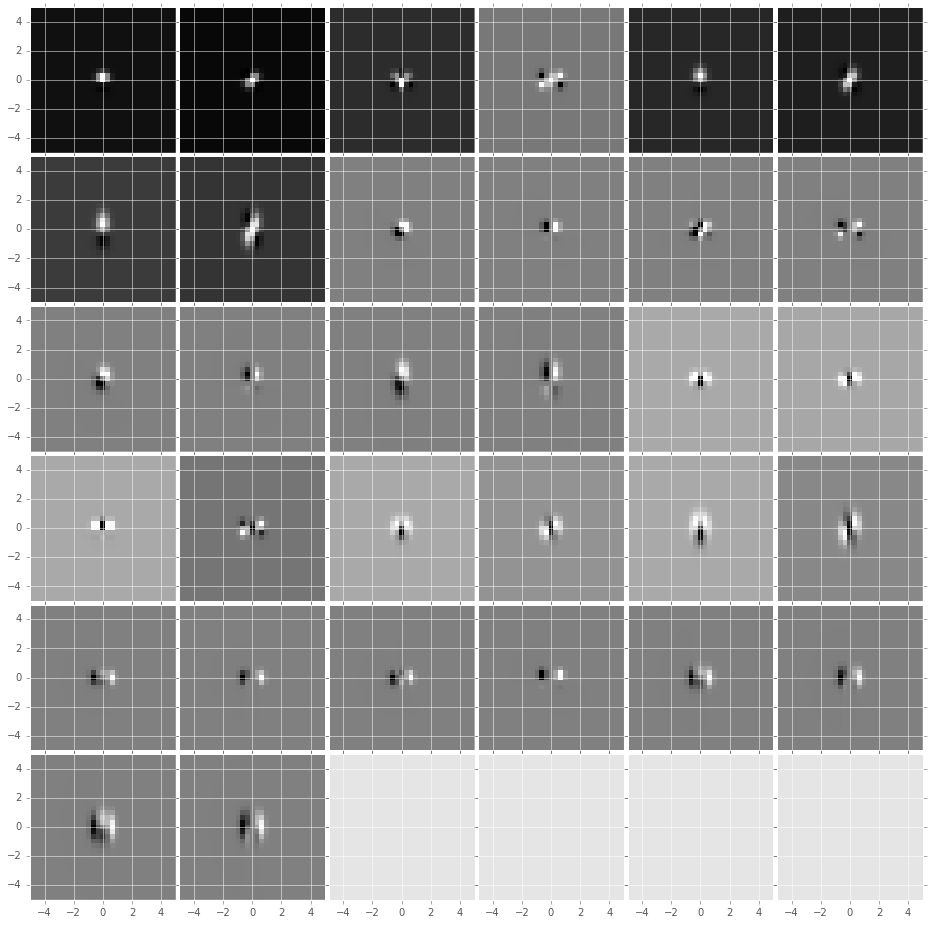

In [128]:
print basis[0].shape, x0.shape, grid.shape, basis[0].reshape(x0.shape).shape

fig = plt.figure(1, (16., 16.))
igrid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(6, 6),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )
extent = (x0.min()+10, x0.max()-10, y0.min()+10, y0.max()-10)
for i in range(32):
    igrid[i].imshow(basis[i].reshape(x0.shape), origin='lower', interpolation='none', cmap='gray', extent=extent)

In [ ]:
basis = np.vstack(basis).T  # put the bases into columns
print basis.shape, basis[0].shape, basis[0].reshape(x0.shape).shape

Make the two "images". `im1` is the template, `im2` is the science image.

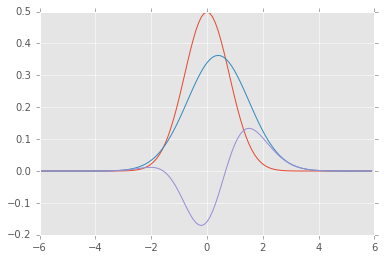

In [8]:
im1 = gaussian(x, m=0.0, s=0.8)  # template
im2 = gaussian(x, m=0.4, s=1.1)  # science image; include a slight registration error
plt.plot(x, im1); plt.plot(x, im2); plt.plot(x, im2-im1)

Convolve im2 with the basis functions, and make these the *new* bases.

(120,) (120,) (120,) (120,)


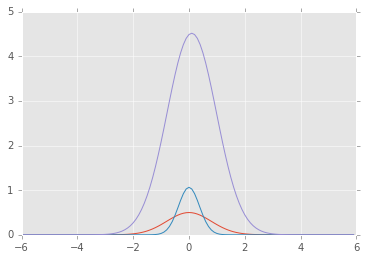

In [9]:
# Test convolve template with the first basis
tmp = np.convolve(im1, basis[:,0], mode='same')
print im2.shape, basis[:,0].shape, tmp.shape, x.shape
plt.plot(x, im1)
plt.plot(x, basis[:,0])
plt.plot(x, tmp)

In [10]:
basis2 = [np.convolve(im1, b, mode='same') - im1 for b in basis.T]
basis2 = np.vstack(basis2).T
print basis2.shape

(120, 8)


Do the linear fit to compute the matching kernel. The resulting fit is the convolved diffim.

Here we are plotting the resulting fitted diffim (red) vs. the actual diffim (blue)

[-0.06511401 -0.0362048  -0.05463125 -0.01312505  0.1257876   0.05720871
  0.00165638  0.00016149]
(120, 8) (120,)


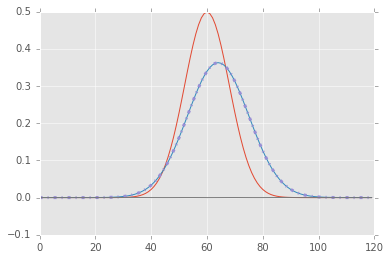

In [11]:
pars = np.linalg.lstsq(basis2, im2)[0]
print pars
fit = (pars * basis2).sum(1)
print basis2.shape, fit.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(im1)  # original template (red)
plt.plot(fit)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - fit)  # diffim (grey)

Look at the resulting matching kernel by multiplying the fitted parameters times the original basis funcs. and test that actually convolving it with the template gives us a good subtraction.

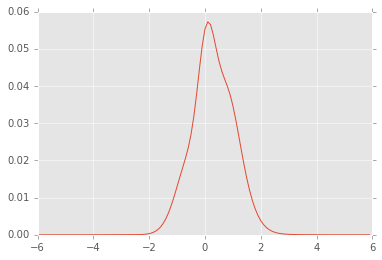

In [12]:
fit = (pars * basis).sum(1)
fit /= fit.sum()
plt.plot(x, fit)  # this plots the matching kernel

Compare the convolved template to the science image. Also plot the new diffim for comparison.

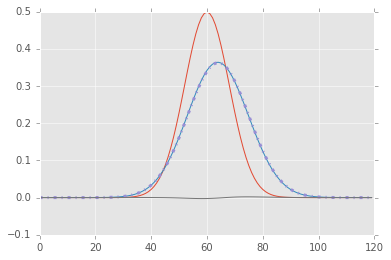

In [13]:
conv_im1 = np.convolve(im1, fit, mode='same')
plt.plot(im1)  # original template (red)
plt.plot(conv_im1)  # convolved template (blue)
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - conv_im1)  # diffim (grey)

Create the $b_i$ and $M_{ij}$ from the A&L (1998) and Becker (2012) papers. This was done wrong in the previous version of notebook 3 (and above), although it gives identical results.

(8,)
(8, 8)
[-0.06511401 -0.0362048  -0.05463125 -0.01312505  0.1257876   0.05720871
  0.00165638  0.00016149]
(120, 8) (120,)
[  2.28073116e-12  -3.50362794e-12   2.35032827e-12  -1.79336233e-12
  -7.98638933e-13   3.76532139e-13   1.11417819e-13  -2.11219930e-14]


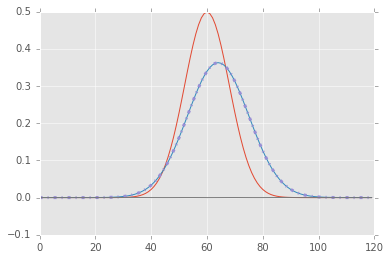

In [14]:
b = (basis2.T * im2).sum(1)
print b.shape

M = np.dot(basis2.T, basis2)
print M.shape

pars2 = np.linalg.lstsq(M, b)[0]
print pars2
fit2 = (pars2 * basis2).sum(1)
print basis2.shape, fit2.shape
#plt.plot(x, im2 - fit)  # science - convolved template (red)
#plt.plot(x, im2 - im1)  # science - original template (blue)
plt.plot(im1)  # original template (red)
plt.plot(fit2)  # convolved template (blue)  -- note looks purple because it's right on top of im2
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - fit2)  # diffim (grey)

print pars2-pars

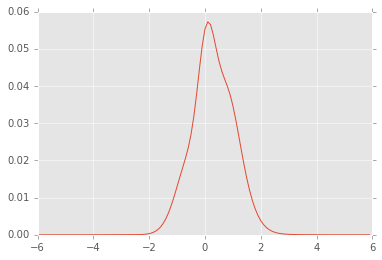

In [15]:
fit2 = (pars2 * basis).sum(1)
fit2 /= fit2.sum()
plt.plot(x, fit2)  # this plots the matching kernel

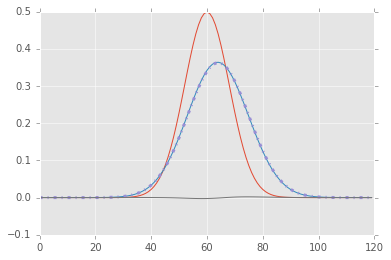

In [16]:
conv_im1a = np.convolve(im1, fit2, mode='same')
plt.plot(im1)  # original template (red)
plt.plot(conv_im1a)  # convolved template (blue)
plt.plot(im2, ls='-.', lw=3)  # science image (dotted, purple)
plt.plot(im2 - conv_im1a)  # diffim (grey)

Add taking into account PSF variations... (next notebook, #4)